In [25]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [26]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [27]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [28]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [29]:
df = preprocess_german(df)

In [30]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [31]:
len(y)

1000

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [33]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [34]:
#calculate the influence of each train data point by retraining
clf_name = 'LogisticRegression'

In [35]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)

    clf = eval(clf_name)(input_size=x_train_temp.shape[-1])
    clf.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(x_test_scalar_temp)

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  protected_positive_pred - privileged_positive_pred

In [36]:
import pickle 

data = {'Xtrain': x_train, 'Ytrain': y_train, 'Xtest': x_test}
with open('data.pkl', 'wb') as f:
    pickle.dump(data,f)

In [37]:
dp_ori = demographic_parity(x_train, y_train, x_test)
print(dp_ori)


-0.07884407313540576


In [38]:
# # find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# # results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

# x_train_a = np.copy(x_train)
# y_train_a = np.copy(y_train)

# result = []

# for i in range(len(x_train)):
#     x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
#     y_train_new = np.append(y_train_a, [y_train[i]])
#     res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
#     result.append(res)


In [39]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

result = {}

for i in range(len(x_train)):
    x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
    result[i] = res

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [56]:
# sorted_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [57]:
for key, value in sorted_result.items():
    print("Index:", key, "Result:", value)

Index: 198 Result: -0.0043791655451059786
Index: 690 Result: -0.00429464513435962
Index: 770 Result: -0.003995942510664374
Index: 350 Result: -0.003988885506987505
Index: 553 Result: -0.0038751880638301373
Index: 405 Result: -0.003663448337465458
Index: 52 Result: -0.0035345018841326237
Index: 423 Result: -0.0034065562300383823
Index: 739 Result: -0.0032785228453576787
Index: 386 Result: -0.003156537748873145
Index: 597 Result: -0.0031344300135969227
Index: 620 Result: -0.0028970722109079583
Index: 652 Result: -0.002864789776504062
Index: 238 Result: -0.002792420051991984
Index: 89 Result: -0.002617015782743648
Index: 378 Result: -0.0024981109425425974
Index: 289 Result: -0.0023573270067571706
Index: 161 Result: -0.002226719912141517
Index: 265 Result: -0.0021241474896669388
Index: 429 Result: -0.0021111765876412614
Index: 695 Result: -0.0020978483371436596
Index: 319 Result: -0.0020976602099835873
Index: 626 Result: -0.0019430353306233439
Index: 398 Result: -0.0018935375846922398
Inde

In [62]:
#Define the counts for which to calculate dp
counts_to_check = [0, 10, 50, 100, 150, 200]

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 10 data points: {0: -0.07884407, 10: -0.042600367777049564}
Demographic Parity for first 50 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957}
Demographic Parity for first 100 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357}
Demographic Parity for first 150 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357, 150: 0.07955599455162887}
Demographic Parity for first 200 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357, 150: 0.07955599455162887, 200: 0.09316234281286595}


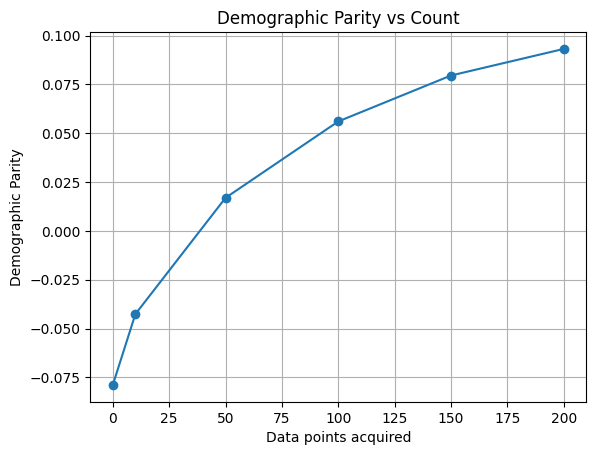

In [65]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [66]:
#Define the counts for which to calculate dp
counts_to_check = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 5 data points: {0: -0.07884407, 5: -0.05863709654659033}
Demographic Parity for first 10 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564}
Demographic Parity for first 15 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064}
Demographic Parity for first 20 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744}
Demographic Parity for first 25 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744, 25: -0.012711191549897194}
Demographic Parity for first 30 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744, 25: -0.012711191549897194, 30: -0.006060321349650621}
Demographic Parity for first 35 data points: {0: -0.07884407, 5: -0.058637

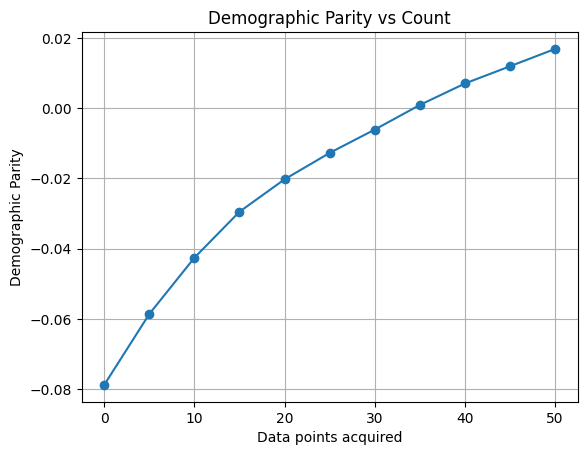

In [67]:
import matplotlib.pyplot as plta

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plta.plot(counts, dp_values, marker='o')
plta.title('Demographic Parity vs Count')
plta.xlabel('Data points acquired')
plta.ylabel('Demographic Parity')
plta.grid(True)
plta.show()

In [ ]:
for count, dp_value in dp.items():
    print(f"Demographic Parity for first {count} data points: {dp_value}")

In [41]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [42]:
del_F_del_theta = del_spd_del_theta(clf, x_test_orig, x_test_scalar, y_test)

In [43]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


  0%|          | 0/800 [00:00<?, ?it/s]

100%|██████████| 800/800 [00:05<00:00, 137.90it/s]


In [44]:
print(hessian_all_points.shape)

(800, 19, 19)


In [45]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [46]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [47]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [48]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta)) 
# it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [49]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
inf = inf * 0.00125
print(inf.shape)

(800,)


ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

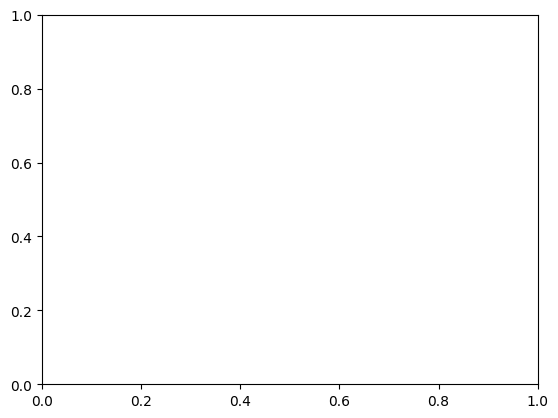

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated diff in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()
